# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp
import pandas as pd
from sklearn.linear_model import LogisticRegression

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [38]:
# Distribution for continuous features
class ContFeatureParam:

    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################

        mean = X.mean()
        variance = X.var(ddof=0)
        return mean, variance

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self, val, theta):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        return norm.pdf(val, loc=theta[0], scale=(theta[1]+10**-9)**0.5)+10**-9


# Distribution for binary features
class BinFeatureParam:

    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution
        # so that it best describes the input data X
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        occurences = X.shape[0]


        unique, counts = np.unique(X, return_counts=True)
        if len(unique) > 2:
            raise AssertionError("more than 2 categories in binary")

        prob = (counts[0]+1) / (occurences + 2)
        

        return prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self, val, p):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        probVector = np.where(val == 0, p, 1-p) 
        return probVector
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


# Distribution for categorical features
class CatFeatureParam:

    def estimate(self, X):

        # TODO: Estimate the parameters for the Multinoulli distribution
        # so that it best describes the input data X
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        occurences = X.shape[0]
        unique_cat = np.unique(X)
        prob = np.zeros(unique_cat.shape)               

        for indx in range(len(unique_cat)):
            prob[indx] = (np.count_nonzero(X == unique_cat[indx])+1) / (occurences+len(unique_cat))
        return prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_probability(self, val, theta):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        prob = np.zeros(len(val))
        theta = theta[:np.where(theta == 0)[0][0]]
        for i in range(len(theta)):
            prob = np.where(val == i, theta[i], prob)
        prob = np.where(prob == 0, 10**-6, prob)
        return prob
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [42]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels


    def __init__(self, feature_types=[], num_classes=0):


        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################

        self.pi = [] # probability of class y
        self.feature_types = np.array(feature_types)
        self.total_features = len(feature_types)
        self.num_classes = num_classes
        self.uclass = np.unique(np.array(y)) # unique classes in dataset
        self.cont = ContFeatureParam()
        self.bin = BinFeatureParam()
        self.cat = CatFeatureParam()

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        # The code below is just for compilation.
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        X = np.array(X)


        self.theta = np.zeros((self.num_classes, self.total_features, 20)) #Theta is 3 dimensional array which stores probabilities
                                                                            #for all possible data (cont, binary, multinoulli)

        for classnr in range(self.num_classes):
            self.pi.append(y[y == self.uclass[classnr]].size / y.size)
            for feature in range(self.total_features):
                obs = np.array(X[y == self.uclass[classnr], feature]) # observations in X for specific class and feature
                if self.feature_types[feature] == 'r':
                    self.theta[classnr, feature, 0:2] = self.cont.estimate(obs)
                if self.feature_types[feature] == 'b':
                    self.theta[classnr, feature, 0] = self.bin.estimate(obs)
                if self.feature_types[feature] == 'c':
                    prob = self.cat.estimate(obs)
                    self.theta[classnr, feature, range(len(prob))] = prob
        return self


        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):

        numerator = np.ones((X.shape[0], self.num_classes)) * np.log(self.pi)

        for Class in range(self.num_classes):       #bayes formula
            for feature in range(self.total_features):
                if self.feature_types[feature] == 'r':
                    numerator[:, Class] += np.log(self.cont.get_probability(X[:, feature], self.theta[Class, feature, 0:2]))
                if self.feature_types[feature] == 'b':
                    numerator[:, Class] += np.log(self.bin.get_probability(X[:, feature], self.theta[Class, feature, 0]))
                if self.feature_types[feature] == 'c':
                    numerator[:, Class] += np.log(self.cat.get_probability(X[:, feature], self.theta[Class, feature, :]))
        denominator = logsumexp(numerator, axis=1)

        self.pi.clear()
        return self.uclass[np.argmax(numerator - denominator[:, np.newaxis], axis=1)]

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r','r','r','r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy)

Accuracy: 1.0


In [5]:
ytrain.shape

(120,)

## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [44]:

# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X_nbc, X_lr, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros((num_splits,num_runs))
    tst_errs_lr = np.zeros((num_splits,num_runs))#create the error matrix
    N1, D1 = X_nbc.shape
    N2, D2 = X_lr.shape
    if N1!=N2:
        raise('Please check the nunmber of data')
    ratio=np.linspace(0,1,num_splits+2)[1:][:-1]#drop the first and last value because they are '0 'and '1'
    Ntrain = [int(ratio[i] * N1) for i in range(ratio.shape[0])]#create the ratios' array
    for k in range(num_runs):#run 'num_runs' times
        shuffler = np.random.permutation(N1)
        for i in range(len(Ntrain)):
            X_nbc_train = X_nbc[shuffler[:Ntrain[i]]]
            X_lr_train = X_lr[shuffler[:Ntrain[i]]]
            ytrain = y[shuffler[:Ntrain[i]]]
            X_nbc_test = X_nbc[shuffler[Ntrain[i]:]]
            X_lr_test = X_lr[shuffler[Ntrain[i]:]]
            ytest = y[shuffler[Ntrain[i]:]]#devide the train and test sets
            nbc.fit(X_nbc_train, ytrain)
            lr.fit(X_lr_train, ytrain)#tarin the models
            y_lr_predict = lr.predict(X_lr_test)
            y_nbc_predict = nbc.predict(X_nbc_test)#get the predict outcome
            tst_errs_lr[i,k] = np.mean(y_lr_predict == ytest)
            tst_errs_nbc[i,k] = np.mean(y_nbc_predict == ytest)#get the Correct rate
    return tst_errs_nbc.mean(axis=1), tst_errs_lr.mean(axis=1)# return the mean of correct rate
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

The utility function below defines the function for plotting. 

In [7]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

<ipython-input-2-081a6e839dc8>:13: RuntimeWarning: Mean of empty slice.
  mean = X.mean()
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-081a6e839dc8>:14: RuntimeWarning: Degrees of freedom <= 0 for slice
  variance = X.var(ddof=0)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-1de325722125>:67: RuntimeWarning: divide by zero encountered in log
  numerator = np.ones((X.shape[0], self.num_classes)) * np.log(self.pi)
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1761: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
D:\Anaconda3

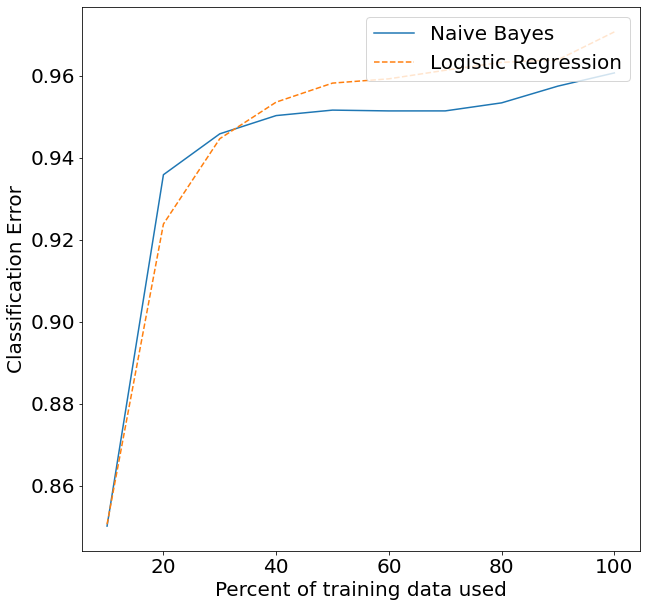

In [8]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
#iris.info()
X=np.array(iris[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].values.tolist())
y=np.array(iris[['species']].values.tolist()).T.reshape(len(iris[['species']]))
nbc_iris = NBC(feature_types=['r','r','r','r'], num_classes=3)
lr_iris = LogisticRegression(solver='newton-cg')#build the model
tst_errs_nbc_iris, tst_errs_lr_iris=compareNBCvsLR(nbc_iris, lr_iris, X, X, y, num_runs=200)#Here I just use 10 times to get average in order to save time
makePlot(tst_errs_nbc_iris,tst_errs_lr_iris)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

For this data set, the feactures(length or width of sepal/petal) are continous distributed, so I set the kind of feature to 'c'. As there's no empty cells, so I use the whole data set. In this example, when the training dataset is small, Logistic regression is better, but for larger training dataset the two methods' performance is almost same.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


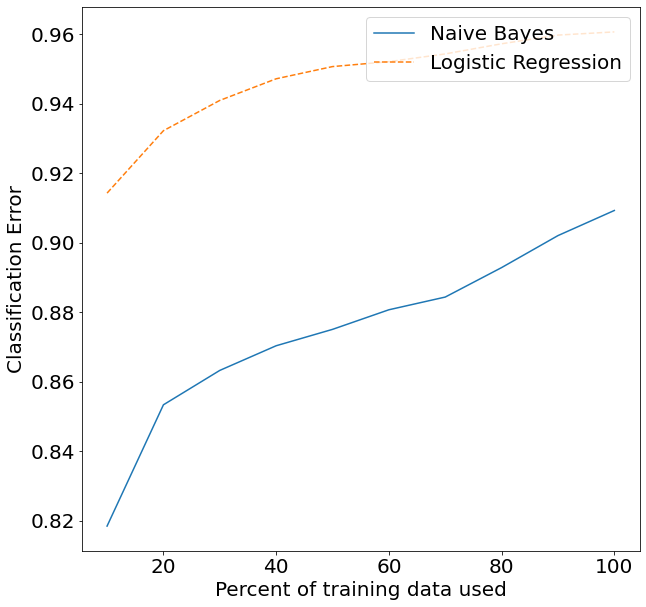

In [9]:
from sklearn.preprocessing import OrdinalEncoder
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('./datasets/voting.csv')
#voting.info()
data=voting.copy()
data=data.dropna(axis=0,how='any').reset_index()#drop all items which contain 'NAN'
X=data[data.columns[2:]].values
ordinal_encoder = OrdinalEncoder()
X_encoded = ordinal_encoder.fit_transform(X)
y=np.array(data[['label']].values.tolist()).reshape(len(data['label']))
nbc_voting = NBC(feature_types=['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], num_classes=2)
lr_voting = LogisticRegression(solver='newton-cg')
tst_errs_nbc_voting, tst_errs_lr_voting=compareNBCvsLR(nbc_voting, lr_voting, X_encoded, X_encoded, y, num_runs=200)
makePlot(tst_errs_nbc_voting,tst_errs_lr_voting)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

There are empty cells in this data set, so firstly I delete all the columns which contain empty cells (Cause 'OrdinalEncoder' don't support np.nan). The values of 16 feactures are 'y' or 'n'(only two values), so I change the values to '1' or '0' and assume they are binary distributed. In this example, the logistic regression is better than NBC

**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

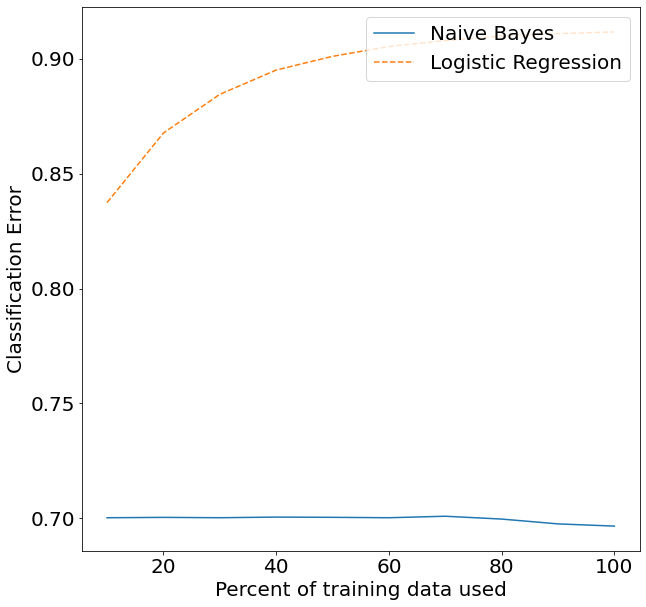

In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
car = pd.read_csv('./datasets/car.csv')
#car.info()
y=np.array(car[['acceptability']].values.tolist()).reshape(len(car['acceptability']))
X_nbc=car[car.columns[:6]].values
X_lr=one_hot_encoder.fit_transform(X_nbc)
X_lr=X_lr.toarray()#prepare the data
nbc_car = NBC(feature_types=['c','c','c','c','c','c'], num_classes=4)
lr_car = LogisticRegression(solver='newton-cg')
tst_errs_nbc_car, tst_errs_lr_car=compareNBCvsLR(nbc_car, lr_car, X_nbc, X_lr, y, num_runs=200)
makePlot(tst_errs_nbc_car,tst_errs_lr_car)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

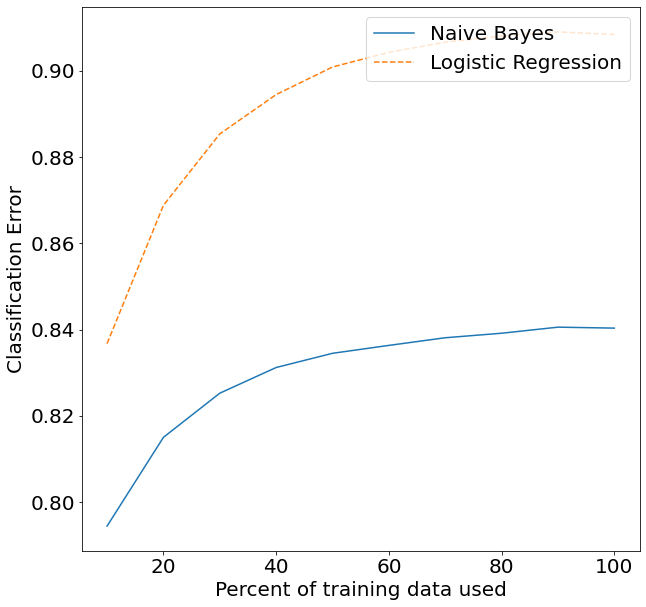

In [45]:
nbc_car = NBC(feature_types=['b','b','b','b','b','b','b','b','b','b',
                             'b','b','b','b','b','b','b','b','b','b','b'], num_classes=4)
lr_car = LogisticRegression(solver='newton-cg')
tst_errs_nbc_car, tst_errs_lr_car=compareNBCvsLR(nbc_car, lr_car, X_lr, X_lr, y, num_runs=200)
makePlot(tst_errs_nbc_car,tst_errs_lr_car)

As the features are categorical distribution, so I set the feature type are all 'c' and use one-hot encoder for every feature in order to put them into the logistic regression. For this data set, logistic regression is much better. What's more, if we put the one hot encoded data into the NBC, the performance is better, but still worse than logistic regression.

**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

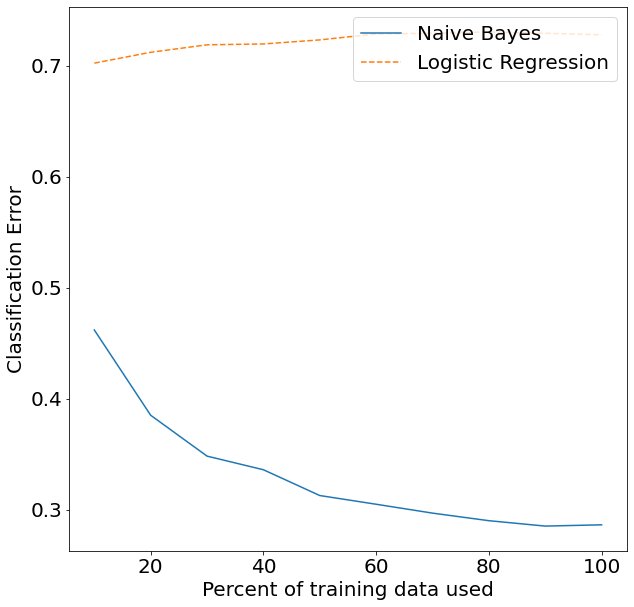

In [118]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
cancer = pd.read_csv('./datasets/breast-cancer.csv')
#cancer.info()
data = cancer.replace('?' , np.nan).dropna()
feature_cat_n = []

#identifying label and categories
y = np.array(data[['Class']].values.tolist()).reshape(len(data['Class']))
categories = data[['age', 'menopause', 'tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']].values

#encoders we are going to use
ordinal_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder()
categories_encoded = one_hot_encoder.fit_transform(categories)

X=categories
X_encoded=categories_encoded.toarray()

feature_types=[]
for i in range(X.shape[1]):
    if np.unique(X[:,i]).shape[0]==2:
        feature_types.append('b')
    else:
        feature_types.append('c')

nbc_cancer = NBC(feature_types = feature_types, num_classes = 2)
lr_cancer = LogisticRegression(solver = 'newton-cg')
tst_errs_nbc_cancer, tst_errs_lr_cancer = compareNBCvsLR(nbc_cancer, lr_cancer, X, X_encoded, y, num_runs=200)
makePlot(tst_errs_nbc_cancer,tst_errs_lr_cancer)

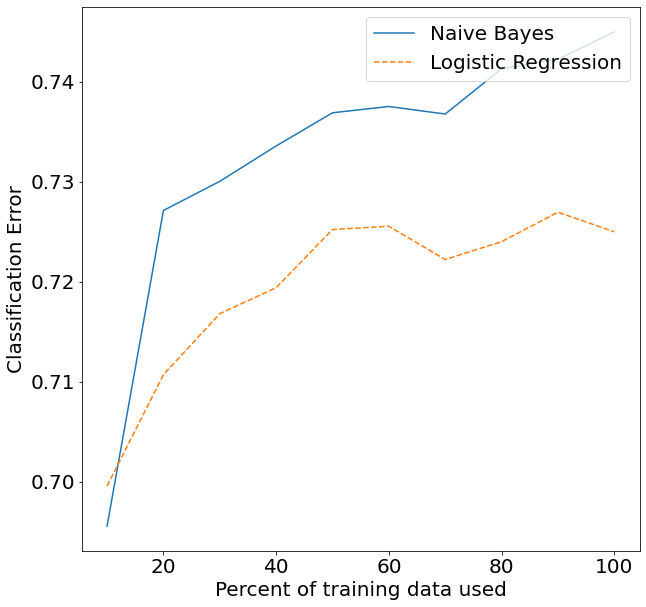

In [119]:
feature_types=[]
for i in range(X_encoded.shape[1]):
    if np.unique(X_encoded[:,i]).shape[0]==2:
        feature_types.append('b')
    else:
        feature_types.append('c')

nbc_cancer = NBC(feature_types = feature_types, num_classes = 2)
lr_cancer = LogisticRegression(solver = 'newton-cg')
tst_errs_nbc_cancer, tst_errs_lr_cancer = compareNBCvsLR(nbc_cancer, lr_cancer, X_encoded, X_encoded, y, num_runs=200)
makePlot(tst_errs_nbc_cancer,tst_errs_lr_cancer)

As some of the features are binary and others are categorical, so I set the correct feature type for each feature.For NBC the original data is enonugh and for logisticregression I use one-hot encoder for every feature. For this data set, logistic regression is much better. What's more, if we put the one hot encoded data into the NBC, the performance is better than logistic regression.

**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

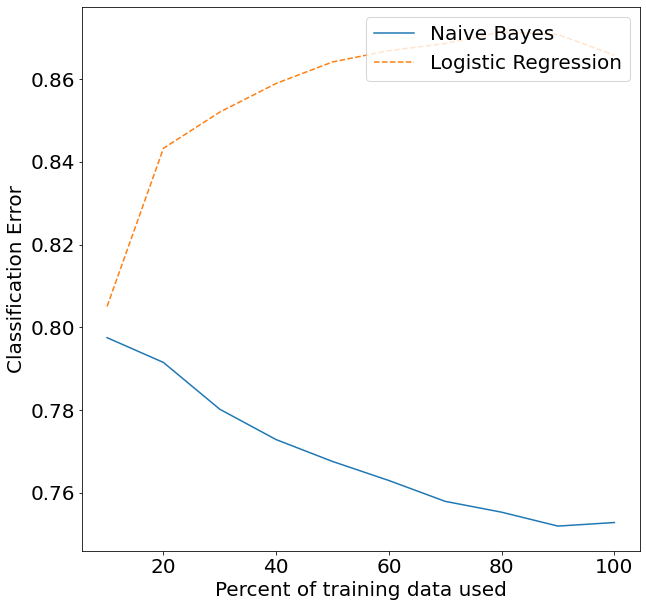

In [12]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
ionosphere = pd.read_csv('./datasets/ionosphere.csv')
#ionosphere.info()
data=ionosphere.drop(['feature2'],axis=1)
X=np.array(data.iloc[:,:33].values.tolist())
y=np.array(ionosphere[['label']].values.tolist()).T.reshape(len(ionosphere[['label']]))
feature_types=['b','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r','r','r','r']
nbc_ionosphere = NBC(feature_types=feature_types, num_classes=2)
lr_ionosphere = LogisticRegression(solver='newton-cg')#build the model
tst_errs_nbc_ionosphere, tst_errs_lr_ionosphere=compareNBCvsLR(nbc_ionosphere, lr_ionosphere, X, X, y, num_runs=200)
makePlot(tst_errs_nbc_ionosphere,tst_errs_lr_ionosphere)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

In this dataset, after I checked all the fetures, I found that feature1 has only two values and feature2 has only 1 values, so I drop the feture2, suppose the feature1 is binary and then put them into the model. For this data set, logistic regression is better

## **Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

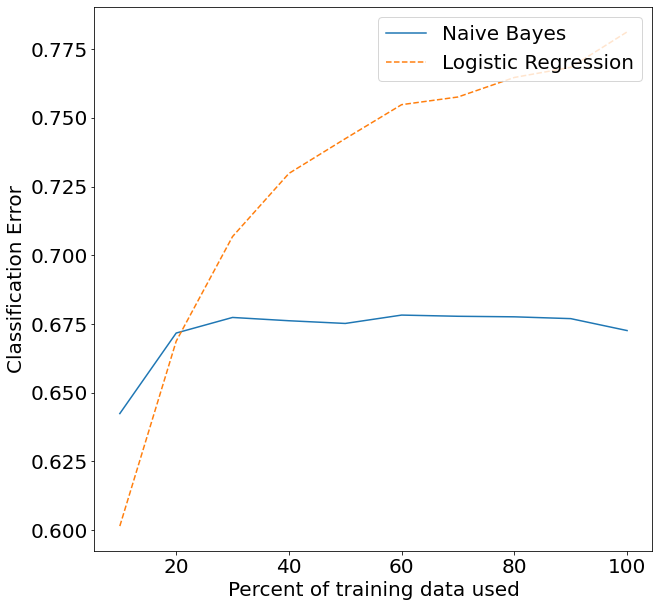

In [13]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
sonar = pd.read_csv('./datasets/sonar.csv')
#sonar.info()
X=np.array(sonar.iloc[:,:60].values.tolist())
y=np.array(sonar[['label']].values.tolist()).T.reshape(len(sonar[['label']]))
feature_types=['r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r',
               'r','r','r','r','r','r','r','r','r','r']
nbc_sonar = NBC(feature_types=feature_types, num_classes=2)
lr_sonar = LogisticRegression(solver='newton-cg')#build the model
tst_errs_nbc_sonar, tst_errs_lr_sonar=compareNBCvsLR(nbc_sonar, lr_sonar, X, X, y, num_runs=200)
makePlot(tst_errs_nbc_sonar,tst_errs_lr_sonar)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

In this dataset, after I checked all the fetures, I found that all the feactures are continous, so I suppose them have Gaussian distribution. For this data set, only for small anount of training set the NBC is better, and for large training data set logistic regression is better.

In [22]:
unique, counts = np.unique(np.array([1,1,1,1,1,1,1,0]), return_counts=True)

8